In [1]:
import sys
import os
import pandas as pd
import numpy as np
import torch
from torch.utils.data import DataLoader
from torchvision import transforms, models
from torchvision.transforms import v2
import matplotlib.pyplot as plt

In [2]:
from pathlib import Path
# include ../../3_Datapreparation
project_dir = Path(os.getcwd()).resolve().parent.parent
sys.path.append(str(project_dir / '3_Data_Preparation'))
sys.path.append(str(project_dir / '4_Modelling/Patrick/Transforms'))
from CT_Datasets import CtScanDataset, CtScanDatasetExtended
from Transforms import *
data_dir = project_dir / 'Data'
model_dir = project_dir / 'Model/3D'
plot_dir = model_dir / "plots"
stats_dir = model_dir / "stats"
plot_dir.mkdir(parents=True, exist_ok=True)
stats_dir.mkdir(parents=True, exist_ok=True)

d:\Programme\anaconda3\envs\deepl5\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


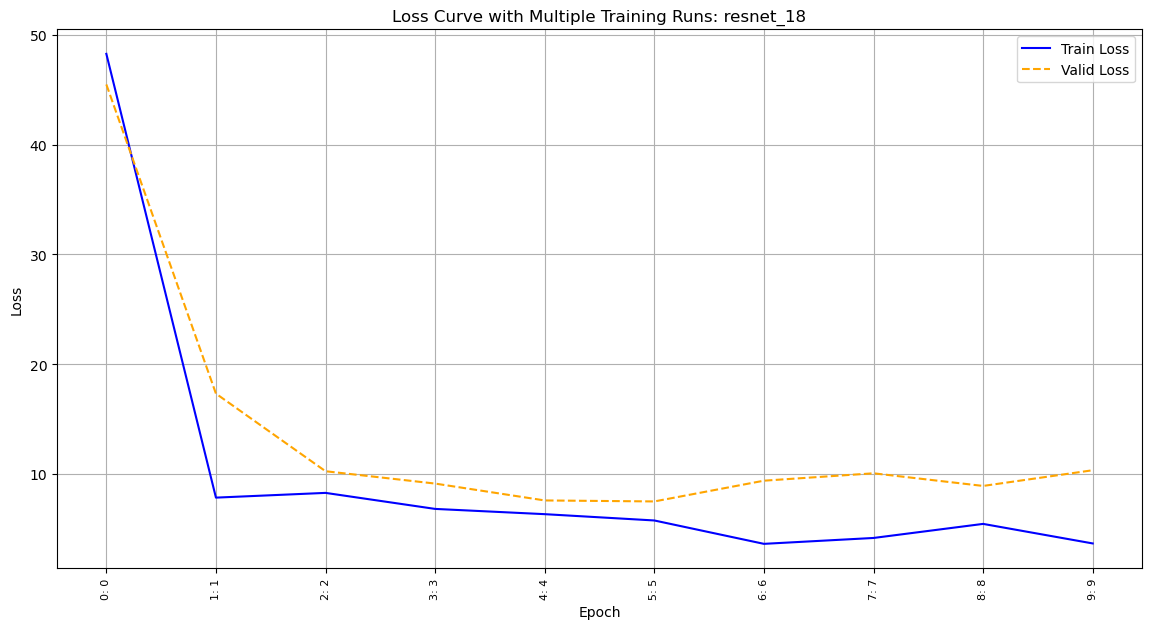

In [3]:
model_type = "resnet_18"
# Read the CSV file, handling repeated headers as new runs
data = pd.read_csv(stats_dir / f"{model_type}_training_logs.csv", comment='#', header=None, names=["epoch", "train_loss", "valid_loss", "mae", "time"])

# Detect and split new training runs
data["new_run"] = data["epoch"] == "epoch"
data["run_id"] = data["new_run"].cumsum()

# Remove rows with header information and reset index
data = data[data["epoch"] != "epoch"]
data.reset_index(drop=True, inplace=True)

# Convert numeric columns to proper types
data["epoch"] = data["epoch"].astype(int)
data[["train_loss", "valid_loss", "mae"]] = data[["train_loss", "valid_loss", "mae"]].astype(float)

# Reset epoch numbers for each run
data["relative_epoch"] = data.groupby("run_id")["epoch"].rank(method="first").astype(int) - 1

# Plotting
plt.figure(figsize=(14, 7))
current_x = 0  # Tracks the x-axis position across runs
x_ticks = []  # To store x-tick positions
x_labels = []  # To store x-tick labels
first_legend = True
for run_id, run_data in data.groupby("run_id"):
    # Plot train and validation loss for this run
    train_x = run_data["relative_epoch"] + current_x
    x_ticks.extend(train_x)
    x_labels.extend([f"{int(epoch)}: {int(tick)}" for epoch, tick in zip(run_data["relative_epoch"], train_x)])

    # Plot train and validation loss for this run
    if first_legend:
        plt.plot(run_data["relative_epoch"] + current_x, run_data["train_loss"], label="Train Loss", color="blue")
        plt.plot(run_data["relative_epoch"] + current_x, run_data["valid_loss"], linestyle="--", label="Valid Loss", color="orange")
        first_legend = False
    else:
        plt.plot(run_data["relative_epoch"] + current_x, run_data["train_loss"], color="blue")
        plt.plot(run_data["relative_epoch"] + current_x, run_data["valid_loss"], linestyle="--", color="orange")
    
    # Update x-axis position
    current_x += run_data["relative_epoch"].max()  # Add space between runs

# Set custom x-ticks and labels
plt.xticks(ticks=x_ticks, labels=x_labels, fontsize=8, rotation=90)

plt.title(f"Loss Curve with Multiple Training Runs: {model_type}")	
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

In [3]:
dataset = CtScanDataset(df_query='BodyPart == "Stamm"', transform=None)

In [4]:
print(dataset[10][0].shape)
print(dataset[10][1])

(511, 512, 512)
58.0


In [5]:
print(dataset[10])

(array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       ...,

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ...,

In [6]:
transformed = CtScanDataset(df_query='BodyPart == "Stamm"', transform=cnn_3d(), return_tensor=True)

print(transformed[0][0].shape)
print(transformed[0][1])

(1, 224, 224, 225)
tensor(73.)


In [7]:
import torchio as tio

HOUNSFIELD_AIR, HOUNSFIELD_BONE = -1000, 1900

transforms = tio.Compose([
    # Convert the input to a tensor
    v2.Lambda(lambda x: x[:, :, np.newaxis]),
    # dimesion D x W x C x H -> C x W x H x D
    tio.Lambda(lambda x: x.permute(2, 1, 3, 0)),
    # Normalize the pixel values to the range [0, 1]
    tio.RescaleIntensity((HOUNSFIELD_AIR, HOUNSFIELD_BONE), (0, 1)),

    # Crop or Pad the input to the target size (600, 512, 512)
    tio.CropOrPad((512, 512, 600)),

    # Scale images to 224x224
    tio.Resize((224, 224, 225)),
    # Normalize with mean and std
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# apply the transform to the dataset
transformed = CtScanDataset(df_query='BodyPart == "Stamm"', transform=transforms, return_tensor=True)

print(transformed[0][0].shape)
print(transformed[0][1])

d:\Programme\anaconda3\envs\deepl5\lib\site-packages\torchio\transforms\preprocessing\intensity\rescale.py:89: RuntimeWarning: Rescaling image "default_image_name" not possible because all the intensity values are the same
  image.set_data(self.rescale(image.data, mask, image_name))


(1, 224, 224, 225)
tensor(73.)


In [8]:
import pyvista as pv
import numpy as np

%matplotlib inline

scan = dataset[10][0]

# Set slice thickness and pixel spacing (adjust these values based on your data)
slice_thickness = 3.0  # Thickness in z-direction
pixel_spacing = [1.171875, 1.171875]  # Spacing in y and x directions

# Create a PyVista grid object from the numpy array
grid = pv.ImageData()

# Set the grid dimensions: shape + 1 because we want to inject our values on the cell data
grid.dimensions = np.array(scan.shape) + 1


# Set the grid spacing
grid.spacing = (slice_thickness, pixel_spacing[0], pixel_spacing[1])  # Spacing in x, y, z directions

# Set the grid origin to (0, 0, 0)
grid.origin = (0, 0, 0)

# Add the data values to the cell data
grid.cell_data["values"] = scan.flatten(order="F")  # Flatten the array in Fortran order

# Visualize the volume
plotter = pv.Plotter()
opacity = [0, 0, 0.1, 0.2, 0.4, 0.6, 1]  # Adjust the opacity transfer function
plotter.add_volume(grid, scalars="values", opacity=opacity, cmap="bone")
plotter.show()

ModuleNotFoundError: No module named 'pyvista'

In [9]:
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torch.utils.data import DataLoader, Dataset
from torchvision.models.resnet import ResNet18_Weights
import torchvision.models.video as video_models

In [10]:
from pathlib import Path
project_dir = Path(os.getcwd()).resolve().parent.parent
sys.path.append(str(project_dir / '4_Modelling/Patrick/medicalNet'))

from setting import Options
from model import generate_model
from logger import log

import torch
import numpy as np
from torch import nn
from torch import optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader
import time
from scipy import ndimage
import os

In [11]:
# settting
sets = Options()
sets.target_type = "normal"
sets.phase = 'test'
print(vars(sets))

{'data_root': './data', 'img_list': './data/train.txt', 'n_seg_classes': 2, 'learning_rate': 0.001, 'num_workers': 4, 'batch_size': 1, 'phase': 'test', 'save_intervals': 10, 'n_epochs': 200, 'input_D': 56, 'input_H': 448, 'input_W': 448, 'resume_path': '', 'pretrain_path': 'pretrain/resnet_50.pth', 'new_layer_names': ['conv_seg'], 'no_cuda': True, 'gpu_id': None, 'model': 'resnet', 'model_depth': 50, 'resnet_shortcut': 'B', 'manual_seed': 1, 'ci_test': False, 'save_folder': './resnet_50', 'target_type': 'normal'}


In [12]:
# getting model
sets.resume_path = sets.pretrain_path = project_dir / 'Model/3D/resnet_10.pth'
#checkpoint = torch.load(sets.resume_path)
net, _ = generate_model(sets)
#net.load_state_dict(checkpoint['state_dict'])

D:\Studium\0004_Master_ITS\MITS_2.Semester\R_D\inferring_body_weight_from_ct_scans\4_Modelling\Patrick\medicalNet\resnet.py:173: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  m.weight = nn.init.kaiming_normal(m.weight, mode='fan_out')


In [13]:
import torch
import torch.nn as nn

class ResNetRegression(nn.Module):
    def __init__(self, pretrained_model, num_outputs=1):
        super(ResNetRegression, self).__init__()
        
        # Keep all layers of the pretrained model
        self.backbone = nn.Sequential(*list(pretrained_model.children())[:-1])
        
        # Add global average pooling (if not already included in your pretrained model)
        self.global_pool = nn.AdaptiveAvgPool3d(1)
        
        # Add the regression head (a fully connected layer)
        self.fc = nn.Linear(2048, num_outputs)  # 2048 is the output of the last conv layer
        
    def forward(self, x):
        # Forward pass through the backbone
        x = self.backbone(x)
        
        # Global average pooling to reduce the 3D output to a single vector
        x = self.global_pool(x)
        
        # Flatten the pooled output
        x = torch.flatten(x, 1)
        
        # Regression output
        x = self.fc(x)
        
        return x

In [14]:
# Instantiate the new regression model
model = ResNetRegression(net, num_outputs=1)
print(model)

ResNetRegression(
  (backbone): Sequential(
    (0): Conv3d(1, 64, kernel_size=(7, 7, 7), stride=(2, 2, 2), padding=(3, 3, 3), bias=False)
    (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool3d(kernel_size=(3, 3, 3), stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv3d(64, 64, kernel_size=(1, 1, 1), stride=(1, 1, 1), bias=False)
        (bn1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
        (bn2): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv3d(64, 256, kernel_size=(1, 1, 1), stride=(1, 1, 1), bias=False)
        (bn3): BatchNorm3d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (dow

In [15]:
dataset = CtScanDataset(df_query='BodyPart == "Stamm"', transform=transforms)

In [ ]:
# get the prediction for the first sample
sample = dataset[0][0]
print(sample.shape)
# make it to a tensor from the numpy array
sample = torch.from_numpy(sample).unsqueeze(0).float()
print(sample.shape)
prediction = model(sample)
print(prediction)

d:\Programme\anaconda3\envs\deepl5\lib\site-packages\torchio\transforms\preprocessing\intensity\rescale.py:89: RuntimeWarning: Rescaling image "default_image_name" not possible because all the intensity values are the same
  image.set_data(self.rescale(image.data, mask, image_name))


(1, 224, 224, 225)
torch.Size([1, 1, 224, 224, 225])
torch.Size([1, 1, 224, 224, 225])
tensor([[0.3663]], grad_fn=<AddmmBackward0>)


In [ ]:
# train/validation split
train_set, val_set = torch.utils.data.random_split(dataset, [0.8, 0.2], generator=torch.Generator().manual_seed(42))

In [ ]:
#make the trainset smaller
train_set = torch.utils.data.Subset(train_set, range(0, 10))

In [ ]:
# Hyperparameters
learning_rate = 0.001
num_epochs = 1
batch_size = 1

# Loss function and optimizer
criterion = nn.MSELoss()  # Mean Squared Error Loss for regression
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Assuming you have your dataset ready
train_loader = DataLoader(dataset=train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset=val_set, batch_size=batch_size, shuffle=False)

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print("Device:", device)

Device: cpu


In [ ]:
# Initialize lists to store losses
train_losses = []
val_losses = []

# Training and validation loop
for epoch in range(num_epochs):
    model.train()
    running_train_loss = 0.0
    
    # Training loop
    for inputs, targets in train_loader:
        inputs, targets = inputs.float().to(device), targets.float().to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), targets)
        loss.backward()
        optimizer.step()

        running_train_loss += loss.item()

    # Compute the average training loss for this epoch
    avg_train_loss = running_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    
    # Validation loop (no gradients needed)
    model.eval()
    running_val_loss = 0.0
    
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.float().to(device), targets.float().to(device)

            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), targets)
            running_val_loss += loss.item()

    # Compute the average validation loss for this epoch
    avg_val_loss = running_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    # Print epoch summary
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')

d:\Programme\anaconda3\envs\R_D\Lib\site-packages\torchio\transforms\preprocessing\intensity\rescale.py:89: RuntimeWarning: Rescaling image "default_image_name" not possible because all the intensity values are the same
  image.set_data(self.rescale(image.data, mask, image_name))
d:\Programme\anaconda3\envs\R_D\Lib\site-packages\torchio\transforms\transform.py:168: RuntimeWarning: Output shape (224, 224, 225) != target shape (224, 224, 224). Fixing with CropOrPad
  transformed = self.apply_transform(subject)
d:\Programme\anaconda3\envs\R_D\Lib\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


tensor(9934.2197, grad_fn=<MseLossBackward0>)
tensor(5830.8394, grad_fn=<MseLossBackward0>)
tensor(4830.4155, grad_fn=<MseLossBackward0>)
tensor(990.0189, grad_fn=<MseLossBackward0>)
tensor(4942.9980, grad_fn=<MseLossBackward0>)
tensor(3295.8499, grad_fn=<MseLossBackward0>)
tensor(7327.4263, grad_fn=<MseLossBackward0>)
tensor(2153.8467, grad_fn=<MseLossBackward0>)
tensor(3011.2346, grad_fn=<MseLossBackward0>)
tensor(1517.7406, grad_fn=<MseLossBackward0>)
Epoch [1/1], Train Loss: 4383.4590, Val Loss: 45567.6233


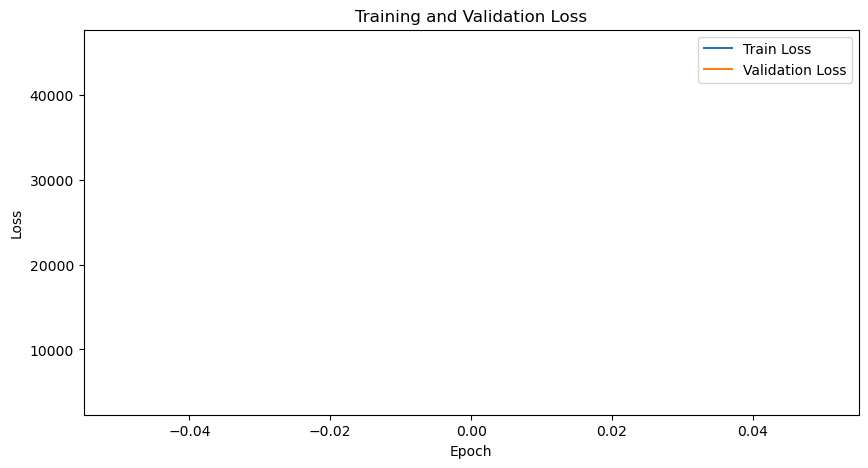

In [ ]:
import matplotlib.pyplot as plt
# Plot the training and validation loss curves
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [ ]:
# Save the trained model
torch.save(resnet.state_dict(), "resnet18CT_Rudimentary.pth")